In [1]:
output_names = ['Logits/Softmax']
input_names = ['input_1']

import tensorflow as tf


def get_frozen_graph(graph_file):
    """Read Frozen Graph file from disk."""
    with tf.gfile.FastGFile(graph_file, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    return graph_def


trt_graph = get_frozen_graph('./trt_graph.pb')

# Create session and load graph
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_sess = tf.Session(config=tf_config)
tf.import_graph_def(trt_graph, name='')


# Get graph input size
for node in trt_graph.node:
    if 'input_' in node.name:
        size = node.attr['shape'].shape
        image_size = [size.dim[i].size for i in range(1, 4)]
        break
print("image_size: {}".format(image_size))


# input and output tensor names.
input_tensor_name = input_names[0] + ":0"
output_tensor_name = output_names[0] + ":0"

print("input_tensor_name: {}\noutput_tensor_name: {}".format(
    input_tensor_name, output_tensor_name))

output_tensor = tf_sess.graph.get_tensor_by_name(output_tensor_name)

Instructions for updating:
Use tf.gfile.GFile.
image_size: [224, 224, 3]
input_tensor_name: input_1:0
output_tensor_name: Logits/Softmax:0


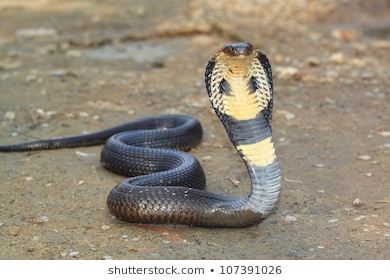

In [18]:
#img_path = './elephant.jpg'
import urllib.request

url = 'https://image.shutterstock.com/image-photo/cobra-snake-260nw-107391026.jpg'  
urllib.request.urlretrieve(url, './file.jpg')  
img_path = './file.jpg'


from IPython.display import Image
Image(filename=img_path) 

In [19]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import numpy as np

# Optional image to test model prediction.

img = image.load_img(img_path, target_size=image_size[:2])
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

feed_dict = {
    input_tensor_name: x
}
preds = tf_sess.run(output_tensor, feed_dict)

# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n01748264', 'Indian_cobra', 0.98438096), ('n01728920', 'ringneck_snake', 0.0036111835), ('n01740131', 'night_snake', 0.0016549602)]


In [11]:
import time
times = []
for i in range(20):
    start_time = time.time()
    one_prediction = tf_sess.run(output_tensor, feed_dict)
    delta = (time.time() - start_time)
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print('average(sec):{:.2f},fps:{:.2f}'.format(mean_delta, fps))

average(sec):0.04,fps:24.68
